# Real Estate Price Analysis: Uncovering Trends
---

## Table of Content
1. Data Exploration
2. Data Cleaning and Preprocessing
3. Data Visualization

## 1. Data Exploration
---
- Data Import
- Summary Statistics
- Null Value Adjustment

In [2]:
#setup

#data manipulation
import pandas as pd
import numpy as np
import io

#data visualization
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.interpolate import make_interp_spline

#display enhancement
from IPython.display import display, HTML

### Data Import:

In [3]:
#importing csv file
df = pd.read_csv('Housing.csv')

#function to generate compact scrollable table
def scrollable_table(df, table_id, title):
    html = f'<h4>{title}</h4>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

#displaying df using 'scrollable_table' function
df_html = scrollable_table(df.head(10), 'Housing', 'Housing Data')
display(HTML(df_html))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

### Summary Statistics:

In [184]:
#summary of df's structure and content:

#function to generate compact scrollable text
def scrollable_text(text, table_id, title):
    html = f'<h4>{title}</h4>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += f'<pre>{text}</pre>'
    html += '</div>'
    return html

#modifying the output of df.info() as a string
info_output = io.StringIO()
df.info(buf=info_output)
info_output = info_output.getvalue()

#displaying df.info() using 'scrollable_text' function
info_html = scrollable_text(info_output, 'info_table_id', 'Df Summary')
display(HTML(info_html))

In [221]:
#summary statistics for numerical features: 

#selecting numerical features and calculating summary statistics
numerical_features = df.select_dtypes(include=[np.number])
num_summary_stats = numerical_features.describe().T

#displaying the numerical feature summary using 'scrollable_table' function
numerical_html = scrollable_table(num_summary_stats, 'numerical', 'Numeric Statistical Overview')
display(HTML(numerical_html))

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [222]:
#summary statistics for categorical features:

#selecting categorical features and calculating summary statistics
categorical_features = df.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T

#displaying the categorical feature summary using 'scrollable_table' function
categorical_html = scrollable_table(cat_summary_stats, 'categorical_features', 'Categorical Statistical Overview')
display(HTML(categorical_html))

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


In [187]:
#summary of null values in df

#calculating null value count and percentage per field 
nv_count = df.isnull().sum()
nv_percentage = (df.isnull().sum() / len(df)) * 100

#locating rows with null values
nv_rows = df[df.isnull().any(axis=1)]

#displaying the null value summary using 'scrollable_table' function
null_values_html = scrollable_table(nv_count.to_frame(), 'null_values', 'Null Value Count')
missing_percentage_html = scrollable_table(nv_percentage.to_frame(), 'missing_percentage', 'Null Value Percentage')
nv_rows_html = scrollable_table(nv_rows.head(10), 'rows_with_missing_values', 'Null Value Rows')

display(HTML(null_values_html + missing_percentage_html + nv_rows_html))

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
Street,0
Alley,1369
LotShape,0
LandContour,0
Utilities,0


## 2. Data Cleaning and Preprocessing
---
- Null Value Adjustment
- Outlier Adjustment

### Null Value Adjustment:

In [4]:
#imputing missing data

#creating a copy of the original df to perform cleaning/preprocessing procedures
df_cleaned = df.copy()

#replacing numerical column null values with mean
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].fillna(df_cleaned[numerical_cols].mean())

#replacing categorical columns' null values with 'missing'
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna('missing')

df_cleaned_html = scrollable_table(df_cleaned.head(10), 'df_cleaned', 'Df w/ Null Values Adjusted')
display(HTML(df_cleaned_html))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,missing,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,missing,missing,missing,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,missing,missing,missing,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,missing,missing,missing,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,missing,missing,missing,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,missing,missing,missing,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000000,14115,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,missing,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,missing,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000000,10084,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,missing,missing,missing,0,8,2007,WD,Normal,307000
7,8,60,RL,70.049958,10382,Pave,missing,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,missing,missing,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000000,6120,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,missing,missing,missing,0,4,2008,WD,Abnorml,129900
9,10,19

### Outlier Adjustment:

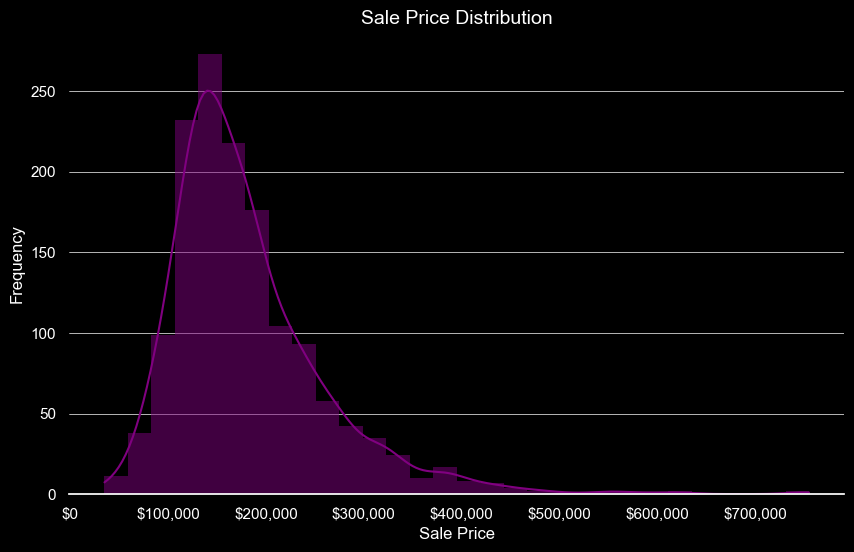

In [189]:
#generating a histogram for the sale price distribution

#configuring the plot layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x="SalePrice", bins=30, kde=True, color='purple', edgecolor='none', ax=ax)
currency_formatter = mticker.StrMethodFormatter("${x:,.0f}")
ax.xaxis.set_major_formatter(currency_formatter)
ax.set_title("Sale Price Distribution", color='white', fontsize=14)
ax.set_xlabel("Sale Price", color='white', fontsize=12)
ax.set_ylabel("Frequency", color='white', fontsize=12)
ax.grid(color='white', linestyle='-', linewidth=0.5, axis='y')
ax.xaxis.grid(False)  
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('white')

plt.show()

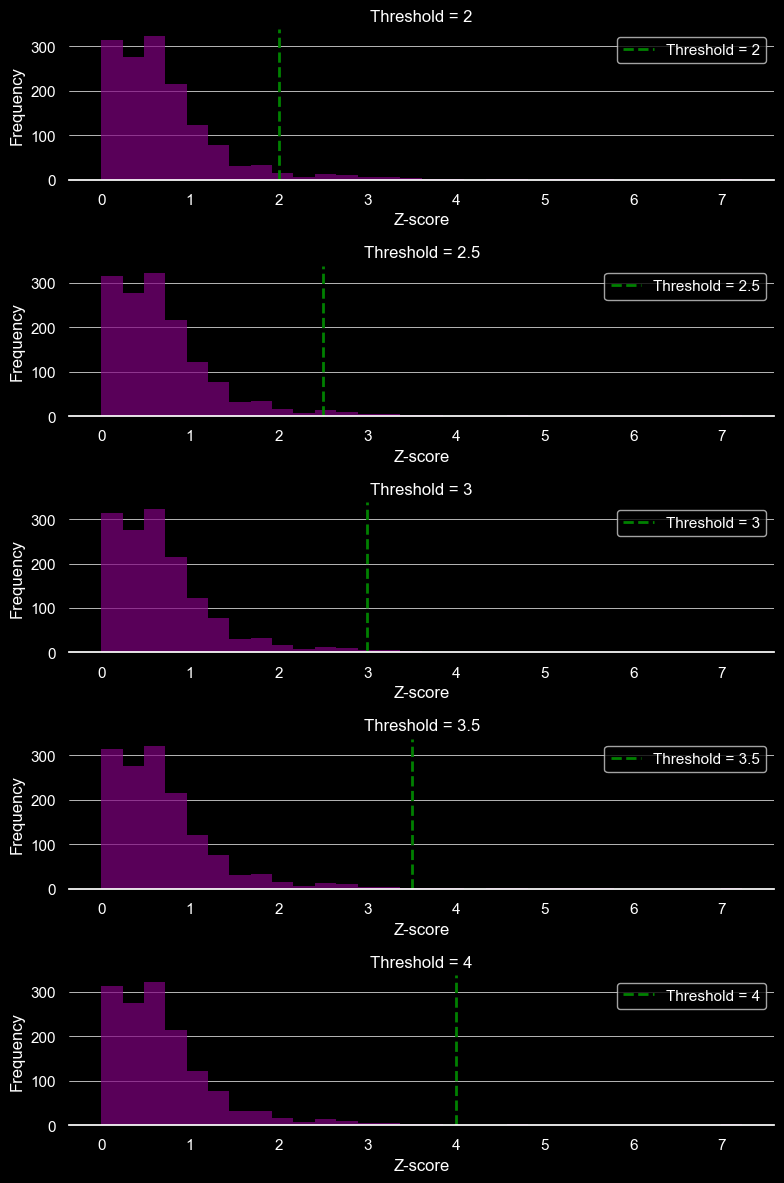

In [190]:
#generating histograms of the z-score distribution
    #exploring thresholds to determine the optimal z-score threshold

#calculating the z-score for the SalePrice column
z_scores = np.abs((df_cleaned['SalePrice'] - df_cleaned['SalePrice'].mean()) / df_cleaned['SalePrice'].std())

#thresholds variations
thresholds = [2, 2.5, 3, 3.5, 4]

#configuring the plot layout
fig, axes = plt.subplots(nrows=len(thresholds), figsize=(8, 12))
plt.style.use('dark_background')

for i, threshold in enumerate(thresholds):
    outliers_mask = z_scores > threshold
    
    sns.histplot(z_scores, bins=30, kde=False, color='purple', edgecolor='none', alpha=0.7, ax=axes[i])
    axes[i].axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    axes[i].set_title(f"Threshold = {threshold}", color='white', fontsize=12)
    axes[i].set_xlabel("Z-score", color='white', fontsize=12)
    axes[i].set_ylabel("Frequency", color='white', fontsize=12)
    axes[i].legend()
    
    axes[i].grid(color='white', linestyle='-', linewidth=0.5, axis='y')
    axes[i].xaxis.grid(False)
    
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_color('white')

plt.tight_layout()
plt.show()

#selecting '3' as the preferred z-score threshold 

In [191]:
#dropping outliers from the dataset using the preferred z-score threshold
threshold = 3
outliers_mask = z_scores > threshold
df_final = df_cleaned[~outliers_mask]

num_removed_outliers = np.sum(outliers_mask)
print(f"Number of outliers removed: {num_removed_outliers}")

Number of outliers removed: 22


## 3. Data Visualization
---
**Key Data Inquiry**:
- Are there any patterns in the sales price distribution across different months of the year?
- How does the neighborhood impact the distribution of SalePrice?
- Is there a relationship between the size of the garage and SalePrice?
- How does the overall condition of the property impact SalePrice?
- Is there a correlation between the number of rooms and SalePrice?

### Are there any patterns in the sales price distribution across different months of the year?

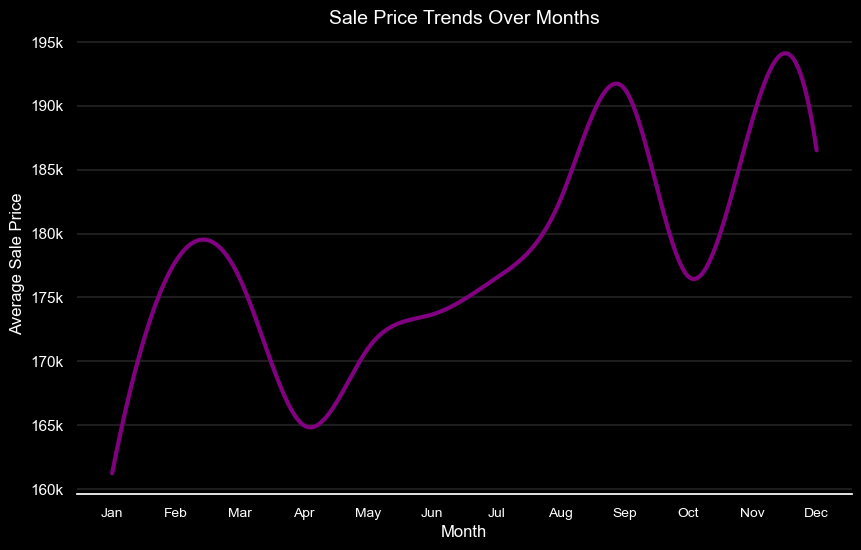

In [217]:
#calculating average SalePrice per month
monthly_avg_price = df_final.groupby('MoSold')['SalePrice'].mean()

#creaing a line plot and configuring the plot layout
sns.set(style='darkgrid', rc={"axes.grid.axis": "y", "axes.grid.which": "both", "axes.grid": True})
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

x_new = np.linspace(monthly_avg_price.index.min(), monthly_avg_price.index.max(), 300)
spl = make_interp_spline(monthly_avg_price.index, monthly_avg_price.values, k=3)
y_smooth = spl(x_new)
ax.plot(x_new, y_smooth, color='purple', linewidth=3)

ax.set_title('Sale Price Trends Over Months', color='white', fontsize=14)
ax.set_xlabel('Month', color='white', fontsize=12)
ax.set_ylabel('Average Sale Price', color='white', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                   color='white', fontsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda value, pos: f'{int(value/1000):,}k'))
ax.yaxis.set_tick_params(colors='white')

ax.grid(color='lightgrey', axis='y', linewidth=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')

plt.show()

### How does the neighborhood impact the distribution of SalePrice?

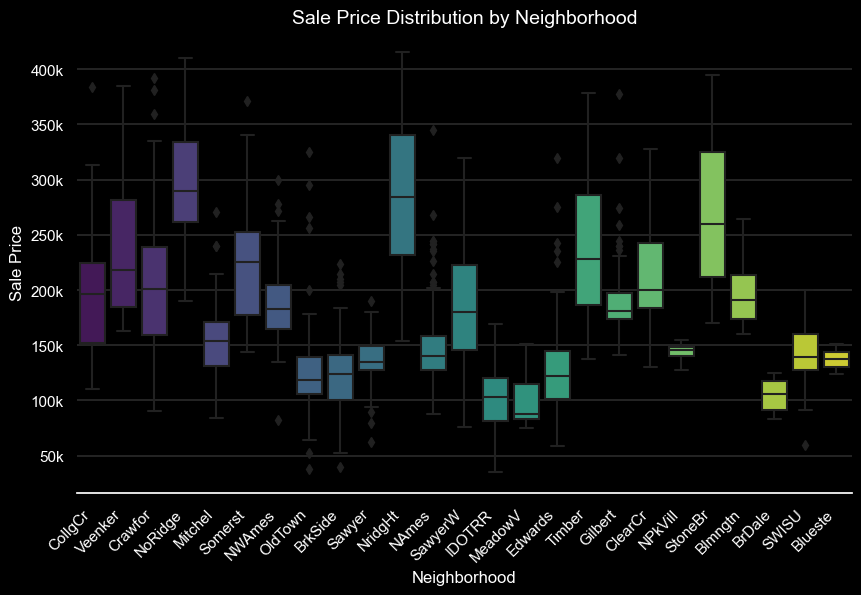

In [215]:
#creaing a box plot and configuring the plot layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_final, x='Neighborhood', y='SalePrice', palette='viridis', ax=ax)

ax.set_title('Sale Price Distribution by Neighborhood', color='white', fontsize=14)
ax.set_xlabel('Neighborhood', color='white', fontsize=12)
ax.set_ylabel('Sale Price', color='white', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.grid(color='white', axis='y', linestyle='-', linewidth=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.grid(False)

ax.set_xticklabels(ax.get_xticklabels(), color='white', rotation=45, ha='right')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

plt.show()

### Is there a relationship between the size of the garage and SalePrice?

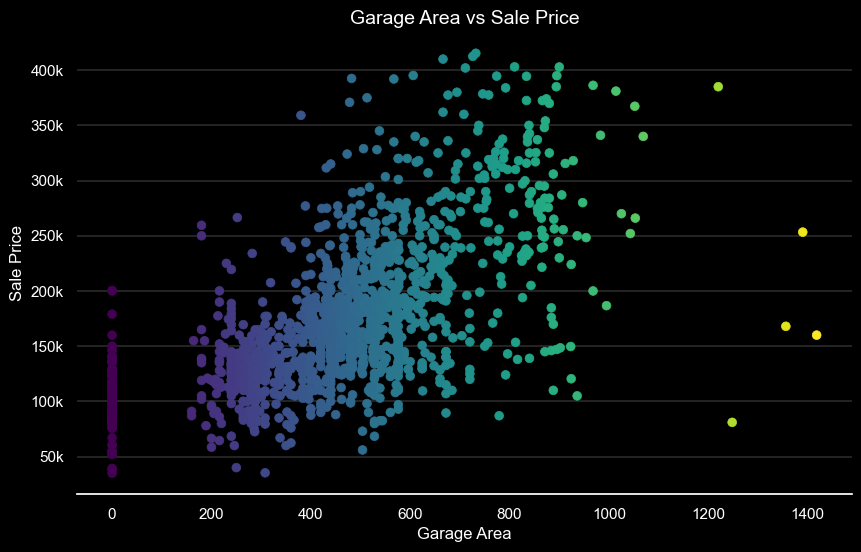

In [212]:
#creating a scatter plot and configuring the plot layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_final, x='GarageArea', y='SalePrice', hue='GarageArea', palette='viridis', s=40, ax=ax, edgecolor=None, legend=False)

ax.set_title('Garage Area vs Sale Price', color='white', fontsize=14)
ax.set_xlabel('Garage Area', color='white', fontsize=12)
ax.set_ylabel('Sale Price', color='white', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(color='white', axis='y', linestyle='-', linewidth=0.2)

for text in (ax.title, ax.xaxis.label, ax.yaxis.label):
    text.set_color("white")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()

### How does the overall condition of the property impact SalePrice?

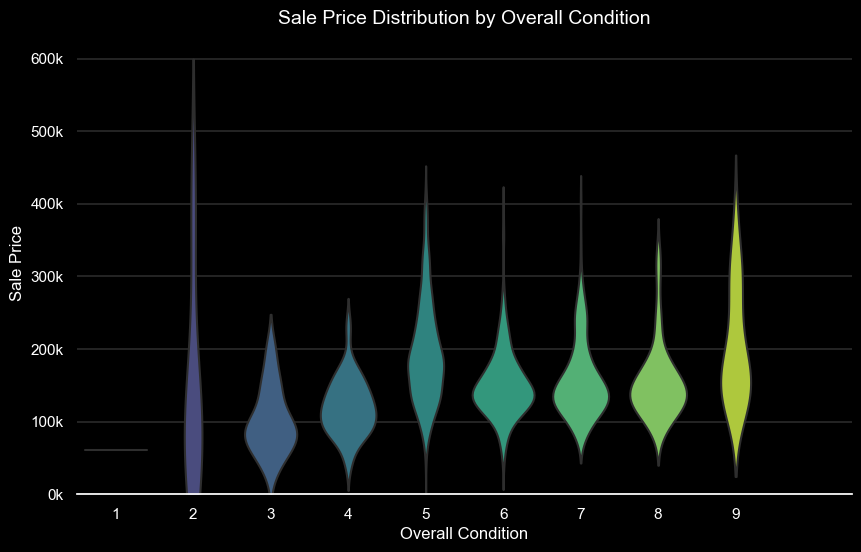

In [213]:
#creating a violin plot and configuring the plot layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=df_final, x='OverallCond', y='SalePrice', inner=None, palette='viridis', ax=ax)

ax.set_title('Sale Price Distribution by Overall Condition', color='white', fontsize=14)
ax.set_xlabel('Overall Condition', color='white', fontsize=12)
ax.set_ylabel('Sale Price', color='white', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.xaxis.grid(False)
ax.grid(color='white', axis='y', linestyle='-', linewidth=0.2)

ax.set_xlim(-0.5, 9.5)
ax.set_ylim(0, ax.get_ylim()[1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.set_ticks_position('none')

plt.show()

### Is there a correlation between the number of rooms and SalePrice?

C:\Users\josep\AppData\Local\Temp\ipykernel_4124\2124397906.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



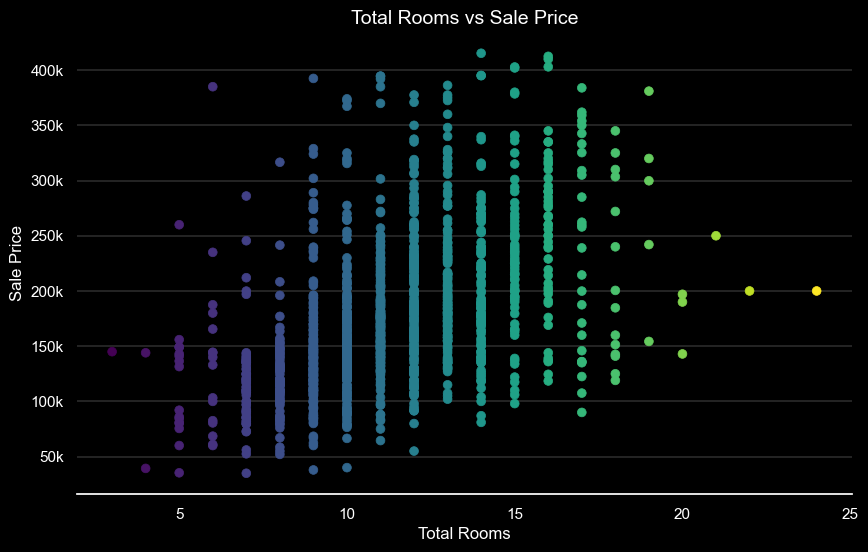

In [204]:
#calculating the total number of rooms in the house
df_final['TotalRooms'] = df_final['TotRmsAbvGrd'] + df_final['FullBath'] + df_final['HalfBath'] + df_final['BedroomAbvGr']

#creating a scatter plot and configuring the plot layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_final, x='TotalRooms', y='SalePrice', hue='TotalRooms', palette='viridis', s=40, ax=ax, edgecolor=None, legend=False)

ax.set_title('Total Rooms vs Sale Price', color='white', fontsize=14)
ax.set_xlabel('Total Rooms', color='white', fontsize=12)
ax.set_ylabel('Sale Price', color='white', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.xaxis.grid(False)
ax.grid(color='white', axis='y', linestyle='-', linewidth=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.set_ticks_position('none')

plt.show()